In [1]:

import sys
from pathlib import Path
from datetime import datetime

from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
# import time
# import shap


# Add the folder containing 'my_functions.py' to sys.path
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))

# Import the module or specific functions
# from /home/michalula/code/epiCausality/epiCode/utils/funcs_extract_mC_profiles_from_BAMs.py
# from funcs_extract_mC_profiles_from_BAMs import system_info, extract_from_bam
from funcs_extract_mC_profiles_from_BAMs import (
    system_info,
    get_reference_sequence,
    create_output_directory,
    extract_from_bam,
    process_extracted_reads,
    visualize_data,
    create_padded_reads,
    plot_padded_reads,
    save_padded_reads,
    remove_low_methylated_reads,
    process_extracted_reads_no_fully_unmethylated,
    create_padded_reads_no_fully_unmethylated
    # main,
)
from funcs_analize_forward_reverse_extracted_mC_reads import analize_forward_reverse_CGs_pipeline

modkit found with expected version 0.2.4


In [2]:
system_info()
date_today = datetime.today().strftime('%Y-%m-%d')
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta')
reg_genome_version = "t2t_v2_0"
region_chr = 'chr1'

# 6500bps: EXACT cutting region  
# chr1:206,583,334-206,589,873
region_start = 206583334    + 20
region_end = 206589874      - 20 
# CD55 TSS start: chr1:206586828-206606065 (+)
# (before TSS: 3474, after TSS: 3026 bps)

region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
region_length = region_end - region_start
print("region_length", region_length)


motifs=['CG,0']
ref_seq_list = get_reference_sequence(ref_genome_path, region_chr, region_start, region_end)

print('region_chr', region_chr)
print('region_start', region_start)
print('region_end', region_end)
print(f'{region_chr}:{region_start}-{region_end}') 

System: Linux
Release: 6.8.0-60-generic
Version: #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
region_length 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTA

In [3]:
! ls /home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/

align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
summary_sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.tsv


In [4]:
# Look at Unedited(NT) T cells at day 28 post EP (with no proteins)

folder_path = "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/"
bam_name = "sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
bam_path = folder_path + bam_name

# Silenced Unedited(NT) day 6:
# folder_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_NT90prD28_P2R9/pod5_converted_basecall/5mCG/to_t2t_v2_0/"
# bam_name = "chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_NT90prD28_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
# bam_path = folder_path + bam_name

# Unedited cells:
#   day 28: "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
#   day 28:  "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

# --------------------------------------

# mC confidence in calling > 99.5%

In [5]:
! pwd

/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/unedited


In [6]:
bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
experiment_name =  day28_NT_D28_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2
Region length: 6500
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.995 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in up_chm13v2.0.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merg…

          |    0%

          | Transferring 53 from reads.CG,0.txt into reads.combined_basemods.h5, new size 53   0% | 00:00<?

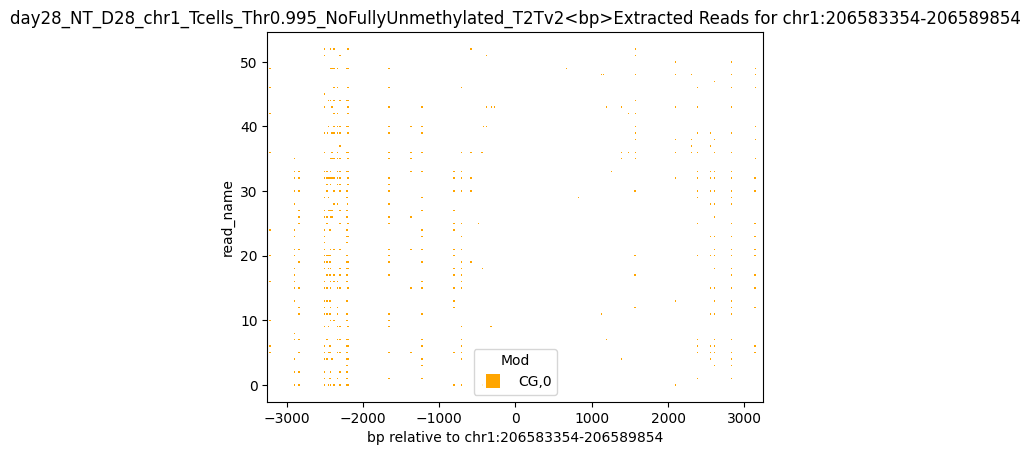

Found read coordinates: 53 reads
Unique read names with methylation: 50
Found 26 reads with full coverage
Reads with methylation data: 50
Overlap between full coverage and methylation: 25
After full coverage filtering: 273 reads with methylation data
Final result: 273 reads with methylation information out of 53 total reads


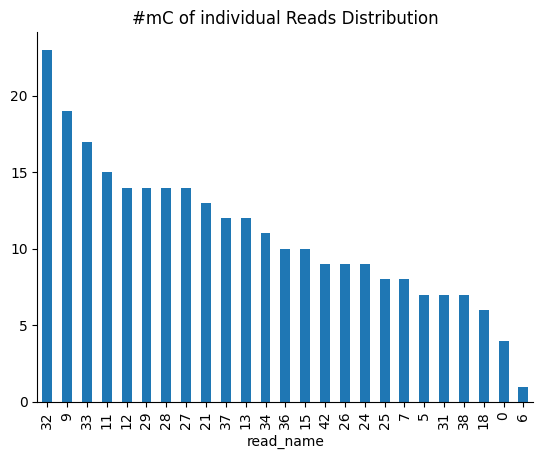

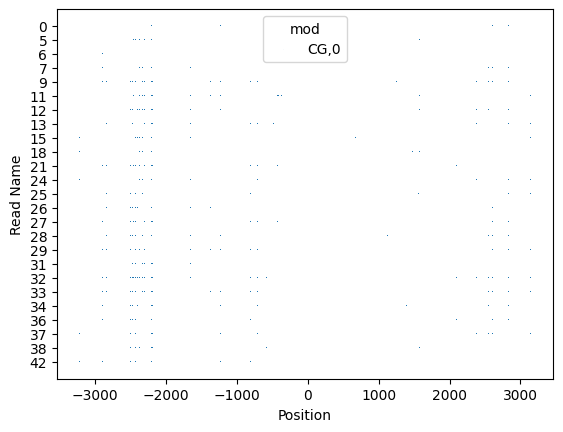

In [ ]:
threshold_mC =  0.995 
experiment_name = "day28_NT_D28_chr1_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
bam_path = bam_path
print(bam_path)

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list, 
    keep_full_coverage_reads_only=keep_full_coverage_reads_only)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")


In [ ]:
CGs_all_NT_D28_mc0995_original = CGs_all
CGs_all_NT_D28_mc0995_original

In [ ]:
threshold_percent = 80
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc0995_remove_low80 = CGs_all
CGs_all_NT_D28_mc0995_remove_low80


In [ ]:
threshold_percent = 70
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc0995_remove_low70 = CGs_all
CGs_all_NT_D28_mc0995_remove_low70


In [ ]:
threshold_percent = 50
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc0995_remove_low50 = CGs_all
CGs_all_NT_D28_mc0995_remove_low50


In [ ]:
threshold_percent = 10
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc0995_remove_low10 = CGs_all
CGs_all_NT_D28_mc0995_remove_low10


In [ ]:
CGs_all_pd = CGs_all_NT_D28_mc0995_remove_low80
CGs_all_0995_remove_low80_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low80_frac = CGs_all_0995_remove_low80_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc0995_remove_low70
CGs_all_0995_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low70_frac = CGs_all_0995_remove_low70_sums  / len(CGs_all_pd) 


CGs_all_pd = CGs_all_NT_D28_mc0995_remove_low50
CGs_all_0995_remove_low50_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low50_frac = CGs_all_0995_remove_low50_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc0995_remove_low10
CGs_all_0995_remove_low10_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low10_frac = CGs_all_0995_remove_low10_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc0995_original
CGs_all_mc0995_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_mc0995_orifinal_frac = CGs_all_mc0995_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_0995_remove_low80_frac)), CGs_all_0995_remove_low80_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >80% * mean(mC)')
plt.bar(np.arange(len(CGs_all_0995_remove_low70_sums)), CGs_all_0995_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_0995_remove_low50_frac)), CGs_all_0995_remove_low50_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >50% * mean(mC)')
plt.bar(np.arange(len(CGs_all_0995_remove_low10_frac)), CGs_all_0995_remove_low10_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >10% * mean(mC)')
plt.bar(np.arange(len(CGs_all_mc0995_orifinal_frac)), CGs_all_mc0995_orifinal_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, original')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fraction of mC for Unedited (NT) T cells CGs day 28')
plt.legend()

# Show the plot
plt.show()

# --------------------------------------

# mC confidence in calling > 95%

In [ ]:

! pwd
threshold_mC =  0.95 
experiment_name = "day28_NT_D28_chr1_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
bam_path = bam_path
print(bam_path)

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list, 
    keep_full_coverage_reads_only=keep_full_coverage_reads_only)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc095_original = CGs_all
CGs_all_NT_D28_mc095_original

In [ ]:

threshold_percent = 80
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc095_remove_low80 = CGs_all
CGs_all_NT_D28_mc095_remove_low80

threshold_percent = 70
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc095_remove_low70 = CGs_all
CGs_all_NT_D28_mc095_remove_low70

threshold_percent = 50
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc095_remove_low50 = CGs_all
CGs_all_NT_D28_mc095_remove_low50

threshold_percent = 10
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc095_remove_low10 = CGs_all
CGs_all_NT_D28_mc095_remove_low10

CGs_all_pd = CGs_all_NT_D28_mc095_remove_low80
CGs_all_095_remove_low80_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low80_frac = CGs_all_095_remove_low80_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc095_remove_low70
CGs_all_095_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low70_frac = CGs_all_095_remove_low70_sums  / len(CGs_all_pd) 


CGs_all_pd = CGs_all_NT_D28_mc095_remove_low50
CGs_all_095_remove_low50_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low50_frac = CGs_all_095_remove_low50_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc095_remove_low10
CGs_all_095_remove_low10_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low10_frac = CGs_all_095_remove_low10_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc095_original
CGs_all_mc095_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_mc095_orifinal_frac = CGs_all_mc095_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_095_remove_low80_frac)), CGs_all_095_remove_low80_frac, snap=False, alpha=0.5, label='mC threshold 95%, >80% * mean(mC)')
plt.bar(np.arange(len(CGs_all_095_remove_low70_sums)), CGs_all_095_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 95%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_095_remove_low50_frac)), CGs_all_095_remove_low50_frac, snap=False, alpha=0.5, label='mC threshold 95%, >50% * mean(mC)')
plt.bar(np.arange(len(CGs_all_095_remove_low10_frac)), CGs_all_095_remove_low10_frac, snap=False, alpha=0.5, label='mC threshold 95%, >10% * mean(mC)')
plt.bar(np.arange(len(CGs_all_mc095_orifinal_frac)), CGs_all_mc095_orifinal_frac, snap=False, alpha=0.5, label='mC threshold 95%, original')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fraction of mC for Unedited (NT) T cells CGs day 28')
plt.legend()



In [ ]:
CGs_all_NT_D28_mc095_remove_low10
dif_mCthresh_08_orig_095 = CGs_all_095_remove_low80_frac - CGs_all_mc095_orifinal_frac
dif_mCthresh_07_orig_095 = CGs_all_095_remove_low70_frac - CGs_all_mc095_orifinal_frac
dif_mCthresh_05_orig_095 = CGs_all_095_remove_low50_frac - CGs_all_mc095_orifinal_frac
dif_mCthresh_01_orig_095 = CGs_all_095_remove_low10_frac - CGs_all_mc095_orifinal_frac

plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(dif_mCthresh_08_orig_095)), dif_mCthresh_08_orig_095, snap=False, alpha=0.5, label='difference between >80% * mean(mC) and original and filtered for mC conf. threshold 95%' )
plt.bar(np.arange(len(dif_mCthresh_07_orig_095)), dif_mCthresh_07_orig_095, snap=False, alpha=0.5, label='difference between >70% * mean(mC) original and filtered for mC conf. threshold 95%' )
plt.bar(np.arange(len(dif_mCthresh_05_orig_095)), dif_mCthresh_05_orig_095, snap=False, alpha=0.5, label='difference between >50% * mean(mC) original and filtered for mC conf. threshold 95%' )
plt.bar(np.arange(len(dif_mCthresh_01_orig_095)), dif_mCthresh_01_orig_095, snap=False, alpha=0.5, label='difference between >10% * mean(mC) original and filtered for mC conf. threshold 95%' )

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC difference')
plt.title('Fraction Differences between mC confidence thresholds \n Unedited (NT) T cells day 28 \n(<70%*mean(mC) removed)')
plt.legend()

# Show the plot
plt.show()

# -------------
# mC confidence threshold 90%

In [ ]:

! pwd
print(bam_path)
threshold_mC =  0.9 
experiment_name = "day28_NT_D28_chr1_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
bam_path = bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list, 
    keep_full_coverage_reads_only=keep_full_coverage_reads_only)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc09_original = CGs_all
CGs_all_NT_D28_mc09_original

In [ ]:

threshold_percent = 100
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc09_remove_low100 = CGs_all
CGs_all_NT_D28_mc09_remove_low100


threshold_percent = 80
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc09_remove_low80 = CGs_all
CGs_all_NT_D28_mc09_remove_low80

threshold_percent = 70
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc09_remove_low70 = CGs_all
CGs_all_NT_D28_mc09_remove_low70

threshold_percent = 50
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc09_remove_low50 = CGs_all
CGs_all_NT_D28_mc09_remove_low50

threshold_percent = 10
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc09_remove_low10 = CGs_all
CGs_all_NT_D28_mc09_remove_low10



In [ ]:

CGs_all_pd = CGs_all_NT_D28_mc09_remove_low100
CGs_all_09_remove_low100_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_09_remove_low100_frac = CGs_all_09_remove_low100_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc09_remove_low80
CGs_all_09_remove_low80_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_09_remove_low80_frac = CGs_all_09_remove_low80_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc09_remove_low70
CGs_all_09_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_09_remove_low70_frac = CGs_all_09_remove_low70_sums  / len(CGs_all_pd) 


CGs_all_pd = CGs_all_NT_D28_mc09_remove_low50
CGs_all_09_remove_low50_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_09_remove_low50_frac = CGs_all_09_remove_low50_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc09_remove_low10
CGs_all_09_remove_low10_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_09_remove_low10_frac = CGs_all_09_remove_low10_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc09_original
CGs_all_mc09_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_mc09_orifinal_frac = CGs_all_mc09_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_09_remove_low100_frac)), CGs_all_09_remove_low100_frac, snap=False, alpha=0.5, label='mC threshold 90%, >100% * mean(mC)')
plt.bar(np.arange(len(CGs_all_09_remove_low80_frac)), CGs_all_09_remove_low80_frac, snap=False, alpha=0.5, label='mC threshold 90%, >80% * mean(mC)')
plt.bar(np.arange(len(CGs_all_09_remove_low70_sums)), CGs_all_09_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 90%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_09_remove_low50_frac)), CGs_all_09_remove_low50_frac, snap=False, alpha=0.5, label='mC threshold 90%, >50% * mean(mC)')
plt.bar(np.arange(len(CGs_all_09_remove_low10_frac)), CGs_all_09_remove_low10_frac, snap=False, alpha=0.5, label='mC threshold 90%, >10% * mean(mC)')
plt.bar(np.arange(len(CGs_all_mc09_orifinal_frac)), CGs_all_mc09_orifinal_frac, snap=False, alpha=0.5, label='mC threshold 90%, original')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fraction of mC for Unedited (NT) T cells CGs day 28')
plt.legend(bbox_to_anchor=(0.5, -0.2)) # show legend bellow the plot



# Plot DIFFERENCES in fractions
 
dif_mCthresh_1_orig_09 = CGs_all_09_remove_low100_frac - CGs_all_mc09_orifinal_frac
dif_mCthresh_08_orig_09 = CGs_all_09_remove_low80_frac - CGs_all_mc09_orifinal_frac
dif_mCthresh_07_orig_09 = CGs_all_09_remove_low70_frac - CGs_all_mc09_orifinal_frac
dif_mCthresh_05_orig_09 = CGs_all_09_remove_low50_frac - CGs_all_mc09_orifinal_frac
dif_mCthresh_01_orig_09 = CGs_all_09_remove_low10_frac - CGs_all_mc09_orifinal_frac

plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(dif_mCthresh_1_orig_09)), dif_mCthresh_1_orig_09, snap=False, alpha=0.5, label='difference between >100% * mean(mC) and original and filtered for mC conf. threshold 95%' )
plt.bar(np.arange(len(dif_mCthresh_08_orig_09)), dif_mCthresh_08_orig_09, snap=False, alpha=0.5, label='difference between >80% * mean(mC) and original and filtered for mC conf. threshold 95%' )
plt.bar(np.arange(len(dif_mCthresh_07_orig_09)), dif_mCthresh_07_orig_09, snap=False, alpha=0.5, label='difference between >70% * mean(mC) original and filtered for mC conf. threshold 95%' )
plt.bar(np.arange(len(dif_mCthresh_05_orig_09)), dif_mCthresh_05_orig_09, snap=False, alpha=0.5, label='difference between >50% * mean(mC) original and filtered for mC conf. threshold 95%' )
plt.bar(np.arange(len(dif_mCthresh_01_orig_09)), dif_mCthresh_01_orig_09, snap=False, alpha=0.5, label='difference between >10% * mean(mC) original and filtered for mC conf. threshold 95%' )

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC difference')
plt.title('Fraction Differences between mC confidence thresholds \n Unedited (NT) T cells day 28 \n(<70%*mean(mC) removed)')
plt.legend(bbox_to_anchor=(0.5, -0.2)) #, loc='upper left')

# Show the plot
plt.show()

# -------------
# mC confidence threshold 70%

In [ ]:

! pwd
print(bam_path)
threshold_mC =  0.7 
experiment_name = "day28_NT_D28_chr1_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
bam_path = bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list, 
    keep_full_coverage_reads_only=keep_full_coverage_reads_only)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc07_original = CGs_all
CGs_all_NT_D28_mc07_original

In [ ]:

threshold_percent = 100
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc07_remove_low100 = CGs_all
CGs_all_NT_D28_mc07_remove_low100


threshold_percent = 80
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc07_remove_low80 = CGs_all
CGs_all_NT_D28_mc07_remove_low80

threshold_percent = 70
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc07_remove_low70 = CGs_all
CGs_all_NT_D28_mc07_remove_low70

threshold_percent = 50
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc07_remove_low50 = CGs_all
CGs_all_NT_D28_mc07_remove_low50

threshold_percent = 10
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc07_remove_low10 = CGs_all
CGs_all_NT_D28_mc07_remove_low10



In [ ]:

CGs_all_pd = CGs_all_NT_D28_mc07_remove_low100
CGs_all_07_remove_low100_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_07_remove_low100_frac = CGs_all_07_remove_low100_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc07_remove_low80
CGs_all_07_remove_low80_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_07_remove_low80_frac = CGs_all_07_remove_low80_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc07_remove_low70
CGs_all_07_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_07_remove_low70_frac = CGs_all_07_remove_low70_sums  / len(CGs_all_pd) 


CGs_all_pd = CGs_all_NT_D28_mc07_remove_low50
CGs_all_07_remove_low50_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_07_remove_low50_frac = CGs_all_07_remove_low50_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc07_remove_low10
CGs_all_07_remove_low10_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_07_remove_low10_frac = CGs_all_07_remove_low10_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc07_original
CGs_all_mc07_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_mc07_orifinal_frac = CGs_all_mc07_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_07_remove_low100_frac)), CGs_all_07_remove_low100_frac, snap=False, alpha=0.5, label='mC threshold 70%, >100% * mean(mC)')
plt.bar(np.arange(len(CGs_all_07_remove_low80_frac)), CGs_all_07_remove_low80_frac, snap=False, alpha=0.5, label='mC threshold 70%, >80% * mean(mC)')
plt.bar(np.arange(len(CGs_all_07_remove_low70_sums)), CGs_all_07_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 70%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_07_remove_low50_frac)), CGs_all_07_remove_low50_frac, snap=False, alpha=0.5, label='mC threshold 70%, >50% * mean(mC)')
plt.bar(np.arange(len(CGs_all_07_remove_low10_frac)), CGs_all_07_remove_low10_frac, snap=False, alpha=0.5, label='mC threshold 70%, >10% * mean(mC)')
plt.bar(np.arange(len(CGs_all_mc07_orifinal_frac)), CGs_all_mc07_orifinal_frac, snap=False, alpha=0.5, label='mC threshold 70%, original')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fraction of mC for Unedited (NT) T cells CGs day 28')
plt.legend(bbox_to_anchor=(0.5, -0.2)) # show legend bellow the plot



# Plot DIFFERENCES in fractions
 
dif_mCthresh_1_orig_07 = CGs_all_07_remove_low100_frac - CGs_all_mc07_orifinal_frac
dif_mCthresh_08_orig_07 = CGs_all_07_remove_low80_frac - CGs_all_mc07_orifinal_frac
dif_mCthresh_07_orig_07 = CGs_all_07_remove_low70_frac - CGs_all_mc07_orifinal_frac
dif_mCthresh_05_orig_07 = CGs_all_07_remove_low50_frac - CGs_all_mc07_orifinal_frac
dif_mCthresh_01_orig_07 = CGs_all_07_remove_low10_frac - CGs_all_mc07_orifinal_frac

plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(dif_mCthresh_1_orig_07)), dif_mCthresh_1_orig_07, snap=False, alpha=0.5, label='difference between >100% * mean(mC) - original' )
plt.bar(np.arange(len(dif_mCthresh_08_orig_07)), dif_mCthresh_08_orig_07, snap=False, alpha=0.5, label='difference between >80% * mean(mC) - original' )
plt.bar(np.arange(len(dif_mCthresh_07_orig_07)), dif_mCthresh_07_orig_07, snap=False, alpha=0.5, label='difference between >70% * mean(mC) - original' )
plt.bar(np.arange(len(dif_mCthresh_05_orig_07)), dif_mCthresh_05_orig_07, snap=False, alpha=0.5, label='difference between >50% * mean(mC) - original' )
plt.bar(np.arange(len(dif_mCthresh_01_orig_07)), dif_mCthresh_01_orig_07, snap=False, alpha=0.5, label='difference between >10% * mean(mC) - original' )

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC difference')
plt.title('Fraction Differences between mC confidence thresholds \n Unedited(NT) T cells day 28 \n using confidence in mC call threshold = 70% ')
plt.legend(bbox_to_anchor=(0.5, -0.2)) #, loc='upper left')

# Show the plot
plt.show()

# -------------
# mC confidence threshold 50%

In [ ]:

! pwd
print(bam_path)
threshold_mC =  0.5
experiment_name = "day28_NT_D28_chr1_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
bam_path = bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list, 
    keep_full_coverage_reads_only=keep_full_coverage_reads_only)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc05_original = CGs_all
CGs_all_NT_D28_mc05_original

In [ ]:

threshold_percent = 100
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc05_remove_low100 = CGs_all
CGs_all_NT_D28_mc05_remove_low100


threshold_percent = 80
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc05_remove_low80 = CGs_all
CGs_all_NT_D28_mc05_remove_low80

threshold_percent = 70
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc05_remove_low70 = CGs_all
CGs_all_NT_D28_mc05_remove_low70

threshold_percent = 50
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc05_remove_low50 = CGs_all
CGs_all_NT_D28_mc05_remove_low50

threshold_percent = 10
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_NT_D28_mc05_remove_low10 = CGs_all
CGs_all_NT_D28_mc05_remove_low10


In [ ]:

CGs_all_pd = CGs_all_NT_D28_mc05_remove_low100
CGs_all_05_remove_low100_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_05_remove_low100_frac = CGs_all_05_remove_low100_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc05_remove_low80
CGs_all_05_remove_low80_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_05_remove_low80_frac = CGs_all_05_remove_low80_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc05_remove_low70
CGs_all_05_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_05_remove_low70_frac = CGs_all_05_remove_low70_sums  / len(CGs_all_pd) 


CGs_all_pd = CGs_all_NT_D28_mc05_remove_low50
CGs_all_05_remove_low50_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_05_remove_low50_frac = CGs_all_05_remove_low50_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc05_remove_low10
CGs_all_05_remove_low10_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_05_remove_low10_frac = CGs_all_05_remove_low10_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc05_original
CGs_all_mc05_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_mc05_orifinal_frac = CGs_all_mc05_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_05_remove_low100_frac)), CGs_all_05_remove_low100_frac, snap=False, alpha=0.5, label='mC threshold 50%, >100% * mean(mC)')
plt.bar(np.arange(len(CGs_all_05_remove_low80_frac)), CGs_all_05_remove_low80_frac, snap=False, alpha=0.5, label='mC threshold 50%, >80% * mean(mC)')
plt.bar(np.arange(len(CGs_all_05_remove_low70_sums)), CGs_all_05_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 50%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_05_remove_low50_frac)), CGs_all_05_remove_low50_frac, snap=False, alpha=0.5, label='mC threshold 50%, >50% * mean(mC)')
plt.bar(np.arange(len(CGs_all_05_remove_low10_frac)), CGs_all_05_remove_low10_frac, snap=False, alpha=0.5, label='mC threshold 50%, >10% * mean(mC)')
plt.bar(np.arange(len(CGs_all_mc05_orifinal_frac)), CGs_all_mc05_orifinal_frac, snap=False, alpha=0.5, label='mC threshold 50%, original')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fraction of mC for Unedited (NT) T cells CGs day 28')
plt.legend(bbox_to_anchor=(0.5, -0.2)) # show legend bellow the plot



# Plot DIFFERENCES in fractions
 
dif_mCthresh_1_orig_05 = CGs_all_05_remove_low100_frac - CGs_all_mc05_orifinal_frac
dif_mCthresh_08_orig_05 = CGs_all_05_remove_low80_frac - CGs_all_mc05_orifinal_frac
dif_mCthresh_07_orig_05 = CGs_all_05_remove_low70_frac - CGs_all_mc05_orifinal_frac
dif_mCthresh_05_orig_05 = CGs_all_05_remove_low50_frac - CGs_all_mc05_orifinal_frac
dif_mCthresh_01_orig_05 = CGs_all_05_remove_low10_frac - CGs_all_mc05_orifinal_frac

plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(dif_mCthresh_1_orig_05)), dif_mCthresh_1_orig_05, snap=False, alpha=0.5, label='difference between >100% * mean(mC) and original and filtered for mC conf. threshold 50%' )
plt.bar(np.arange(len(dif_mCthresh_08_orig_05)), dif_mCthresh_08_orig_05, snap=False, alpha=0.5, label='difference between >80% * mean(mC) and original and filtered for mC conf. threshold 50%' )
plt.bar(np.arange(len(dif_mCthresh_07_orig_05)), dif_mCthresh_07_orig_05, snap=False, alpha=0.5, label='difference between >70% * mean(mC) original and filtered for mC conf. threshold 50%' )
plt.bar(np.arange(len(dif_mCthresh_05_orig_05)), dif_mCthresh_05_orig_05, snap=False, alpha=0.5, label='difference between >50% * mean(mC) original and filtered for mC conf. threshold 50%' )
plt.bar(np.arange(len(dif_mCthresh_01_orig_05)), dif_mCthresh_01_orig_05, snap=False, alpha=0.5, label='difference between >10% * mean(mC) original and filtered for mC conf. threshold 50%' )

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC difference')
plt.title('Fraction Differences between mC confidence thresholds \n Unedited (NT) T cells day 28 \n using confidence in mC call threshold = 50% ')
plt.legend(bbox_to_anchor=(0.5, -0.2)) #, loc='upper left')

# Show the plot
plt.show()

# Compare accross mC confidance calls removing < 70%*mean(mC) reads

In [ ]:


CGs_all_pd = CGs_all_NT_D28_mc05_remove_low70
CGs_all_05_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_05_remove_low70_frac = CGs_all_05_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc07_remove_low70
CGs_all_07_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_07_remove_low70_frac = CGs_all_07_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc09_remove_low70
CGs_all_09_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_09_remove_low70_frac = CGs_all_09_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc095_remove_low70
CGs_all_095_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low70_frac = CGs_all_095_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc0995_remove_low70
CGs_all_0995_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low70_frac = CGs_all_0995_remove_low70_sums  / len(CGs_all_pd) 

# CGs_all_pd = CGs_all_NT_D28_mc07_original
# CGs_all_mc07_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
# CGs_all_mc07_orifinal_frac = CGs_all_mc07_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_05_remove_low70_sums)), CGs_all_05_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 50%')
plt.bar(np.arange(len(CGs_all_07_remove_low70_sums)), CGs_all_07_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 70%')
plt.bar(np.arange(len(CGs_all_09_remove_low70_frac)), CGs_all_09_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 90%')
plt.bar(np.arange(len(CGs_all_095_remove_low70_frac)), CGs_all_095_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 95%')
plt.bar(np.arange(len(CGs_all_0995_remove_low70_frac)), CGs_all_0995_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 99.5%')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fractions of mC called using various Dorado thresholds \n Unedited (NT) T cells day 28 \n(<70%*mean(mC) removed)')
plt.legend(bbox_to_anchor=(0.5, -0.2)) # show legend bellow the plot



# Plot DIFFERENCES in fractions
 
dif_mCthresh_50_995 = CGs_all_05_remove_low70_frac - CGs_all_0995_remove_low70_frac
dif_mCthresh_70_995 = CGs_all_07_remove_low70_frac - CGs_all_0995_remove_low70_frac
dif_mCthresh_90_995 = CGs_all_09_remove_low70_frac - CGs_all_0995_remove_low70_frac
dif_mCthresh_95_995 = CGs_all_095_remove_low70_frac - CGs_all_0995_remove_low70_frac


plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(dif_mCthresh_50_995)), dif_mCthresh_50_995, snap=False, alpha=0.5, label='difference between mC conf. threshold 50 vs 99.5%' )
plt.bar(np.arange(len(dif_mCthresh_70_995)), dif_mCthresh_70_995, snap=False, alpha=0.5, label='difference between mC conf. threshold 70 vs 99.5%' )
plt.bar(np.arange(len(dif_mCthresh_90_995)), dif_mCthresh_90_995, snap=False, alpha=0.5, label='difference between mC conf. threshold 90 vs 99.5%' )
plt.bar(np.arange(len(dif_mCthresh_95_995)), dif_mCthresh_95_995, snap=False, alpha=0.5, label='difference between mC conf. threshold 95 vs 99.5%' )

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC difference')
plt.title('Fraction Differences between mC confidence thresholds \n Unedited(NT) T cells day 28 \n(<70%*mean(mC) removed)')
plt.legend(bbox_to_anchor=(0.5, -0.2)) #, loc='upper left')

# Show the plot
plt.show()

In [ ]:


CGs_all_pd = CGs_all_NT_D28_mc07_remove_low70
CGs_all_07_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_07_remove_low70_frac = CGs_all_07_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc09_remove_low70
CGs_all_09_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_09_remove_low70_frac = CGs_all_09_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc095_remove_low70
CGs_all_095_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low70_frac = CGs_all_095_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_NT_D28_mc0995_remove_low70
CGs_all_0995_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low70_frac = CGs_all_0995_remove_low70_sums  / len(CGs_all_pd) 

# CGs_all_pd = CGs_all_NT_D28_mc07_original
# CGs_all_mc07_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
# CGs_all_mc07_orifinal_frac = CGs_all_mc07_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_07_remove_low70_sums)), CGs_all_07_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 70%')
plt.bar(np.arange(len(CGs_all_09_remove_low70_frac)), CGs_all_09_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 90%')
plt.bar(np.arange(len(CGs_all_095_remove_low70_frac)), CGs_all_095_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 95%')
plt.bar(np.arange(len(CGs_all_0995_remove_low70_frac)), CGs_all_0995_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 99.5%')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fractions of mC called using various Dorado thresholds \n Unedited (NT) T cells day 28 \n(<70%*mean(mC) removed)')
plt.legend(bbox_to_anchor=(0.5, -0.2)) # show legend bellow the plot



# Plot DIFFERENCES in fractions
 
dif_mCthresh_70_995 = CGs_all_07_remove_low70_frac - CGs_all_0995_remove_low70_frac
dif_mCthresh_90_995 = CGs_all_09_remove_low70_frac - CGs_all_0995_remove_low70_frac
dif_mCthresh_95_995 = CGs_all_095_remove_low70_frac - CGs_all_0995_remove_low70_frac


plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(dif_mCthresh_70_995)), dif_mCthresh_70_995, snap=False, alpha=0.5, label='difference between mC conf. threshold 70 vs 99.5%' )
plt.bar(np.arange(len(dif_mCthresh_90_995)), dif_mCthresh_90_995, snap=False, alpha=0.5, label='difference between mC conf. threshold 90 vs 99.5%' )
plt.bar(np.arange(len(dif_mCthresh_95_995)), dif_mCthresh_95_995, snap=False, alpha=0.5, label='difference between mC conf. threshold 95 vs 99.5%' )

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC difference')
plt.title('Fraction Differences between mC confidence thresholds \n Unedited(NT) T cells day 28 \n(<70%*mean(mC) removed)')
plt.legend(bbox_to_anchor=(0.5, -0.2)) #, loc='upper left')

# Show the plot
plt.show()